---
layout: post
title:  "Getting started with Boost, Python, and Numpy"
description: "After failing to find a tutorial that was actually complete, I decided to make one myself."
date: 2020-07-04
categories: [tutorial]
tags: []
math: true
---

As much as we might want all code that we work with to be professional-quality packages in the same language we are working in, it simply won't be the case for the vast majority of us.

Recently, I was investigating how we could replace some perl wrappers that executed C code with something more pythonic. I came across [boost](https://www.boost.org/) - a package designed to try and make exposing C/C++ interfaces a bit simpler to python programs. Well, it includes other languages too, but I'm going to give the python example.

## Setting up boost

Ostensibly, boost installs on both windows and \*nix systems. Not wanting to risk compilation issues, I opened up my [Ubuntu subsystem in windows](https://docs.microsoft.com/en-us/windows/wsl/install-win10)

Perhaps you've already got boost installed, in which case, skip this section, but for completeness, here is what I did.

**Step 1:** Downloaded the [boost 1.73.0 source tarball](https://dl.bintray.com/boostorg/release/1.73.0/source/boost_1_73_0.tar.gz) to my home directory and extracted it with the normal 

```bash
tar -xf boost_1_73_0.tar.gz
```

**Step 2:** Installed a bunch of developer dependencies:

```bash
sudo apt-get install build-essential g++ python-dev autotools-dev libicu-dev build-essential libbz2-dev libboost-all-dev
```

**Step 3:** Went into the extracted boostrap folder and set up the boostrap and specified to build the python libraries:

```bash
./bootstrap.sh --prefix=/usr/ --with-libraries=python
```


**Step 4:** Notice that compilation was failing because anaconda has a slightly different include path than the default python installer (their folder is called python3.7m instead of python3.7). So I opened the `project-config.jam` file in the main boost folder, found the section with a label `#Python configuration` and added my anaconda locations in explicitly:

```bash
# Python configuration
import python ;
if ! [ python.configured ]
{
    using python : 3.7 : "/home/samreay/miniconda3" : /home/samreay/miniconda3/include/python3.7m ;
}
```

**Step 5:** Installed into the `usr` folder:

```bash
sudo ./b2 install
```

And once that was all done, I made sure that under my `/usr/lib` folder I had some `libboost` files - at least ones for python and numpy specifically. For me, debugging compilation issues and fixing the path means it took about 3 hours to do this. I'm hoping with the instructions above it takes you far less time!

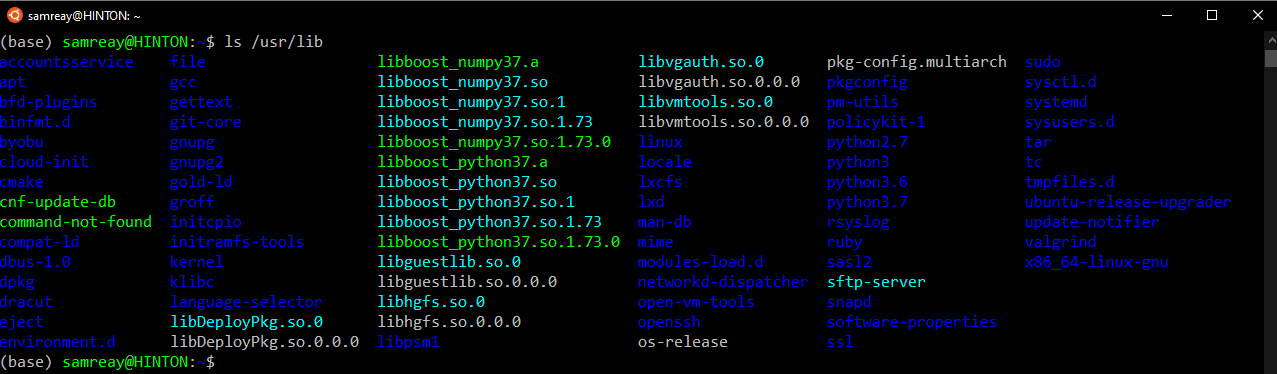

In [1]:
from IPython.display import Image
Image("boost/lib.png")

## Setting up a basic Numpy example

I don't want a useless hello world example, I want an example closer to what I'm doing, which is passing data back and forth. So let us make an example C++ function, that takes an input numpy array and returns an output array which is two elements long. The two elements will be the sum of the array, and the number of elements in it. Simple.

In python, this would just be:

In [2]:
def python_count_and_sum(x):
    return np.sum(x), len(x)

But in C++, sticking to arrays (as it makes it closer to C, although it means no `std::vector` use), I have:

```cpp
void count_and_sum(double* array, int num, double output[]) {
    double sum = 0.0;
    for (int i = 0; i < num; ++i) {
        sum += array[i];
    }
    
    // Set output values
    output[0] = sum;
    output[1] = (double)num;
}
```

In fact, lets skip dripping the code out piece by piece. Here's the entire C++ file, which I named `example.cpp`. The name of the file is important, because it should match what you put in `BOOST_PYTHON_MODULE` (or moreso the library you make needs to have that name). Just keep them all consistent and save yourself a headache.

```cpp
#include <boost/python/numpy.hpp>
#include <boost/scoped_array.hpp>
#include <iostream>
#include <bits/stdc++.h> 

using namespace std;
namespace p = boost::python;
namespace np = boost::python::numpy;


// Actual C++/C code here that does everything
void count_and_sum(double* array, int num, double output[]) {
    double sum = 0.0;
    
    for (int i = 0; i < num; ++i) {
        sum += array[i];
    }
     
    // Set output values
    output[0] = sum;
    output[1] = (double)num;
}

// A few translators here to ensure that numpy datatypes convert to pointers and what not
np::ndarray wrap_count_and_sum(np::ndarray const & array) {
    
    // Make sure we get doubles
    if (array.get_dtype() != np::dtype::get_builtin<double>()) {
        PyErr_SetString(PyExc_TypeError, "Incorrect array data type");
        p::throw_error_already_set();
    }
    
    // Could also pass back a vector, but unsure if you use C++ or C
    static double output[2]; // the static here is important, keeps it around!
    count_and_sum(reinterpret_cast<double*>(array.get_data()), array.shape(0), output);
        
        
    // Turning the output into a numpy array
    np::dtype dt = np::dtype::get_builtin<double>();
    p::tuple shape = p::make_tuple(2); // It has shape (2,)
    p::tuple stride = p::make_tuple(sizeof(double)); // 1D array, so its just size of double
    np::ndarray result = np::from_data(output, dt, shape, stride, p::object());
    return result;

}

// Deciding what to expose in the library python can import
BOOST_PYTHON_MODULE(example) {  // Thing in brackets should match output library name
    Py_Initialize();
    np::initialize();
    p::def("count_and_sum", wrap_count_and_sum);
}
```

Lets break it down. The first function is the "original" C++ code which I want to interface with. To do this, I write a wrapper function, which handles turning all the numpy arrays into C arrays, and vice-versa. Note that adding some type checking here will save you a lot of hassle in the future given how easy it is to mix up numeric types in python.

After the translator, we use `BOOST_PYTHON_MODULE` to initialise the python and numpy components, and then declare that we are exposing the function `wrap_count_and_sum` under the name `count_and_sum`.

So, with this C++ code written, time to compile.

```
g++ -Wall -Wextra -fPIC -shared -I/home/samreay/miniconda3/include/python3.7m/ example.cpp -o example.so -lboost_python37 -lboost_numpy37
```
Interestingly, it only works for me if the libraries go in after the output name.

So this produces the output `example.so`. **This is what you can directly import as a python module. You do not need to turn the `.so` into a `.py` file, it is all done.**

So how can we use it? Super easily:

```python
import numpy as np
import example
x = np.array([1, 2, 3, 4, 5])
sum, count = example.count_and_sum(x.astype(np.double))
print(f"Sum is {sum} from {count} elements")
```


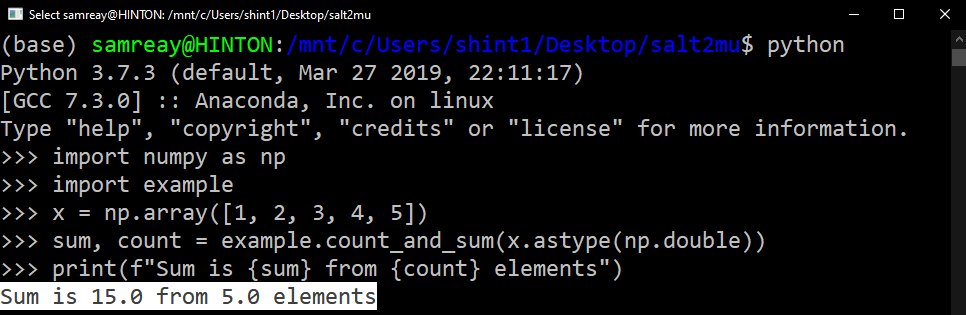

In [4]:
Image("boost/output.png")

You can see that we don't need to do anything else. Import the `.so` file, and call it just like any other python function. 

[**You can find the C++, Python and install.txt files here for convenience.**](/static/notebooks/boost/boost.zip)

Good luck!



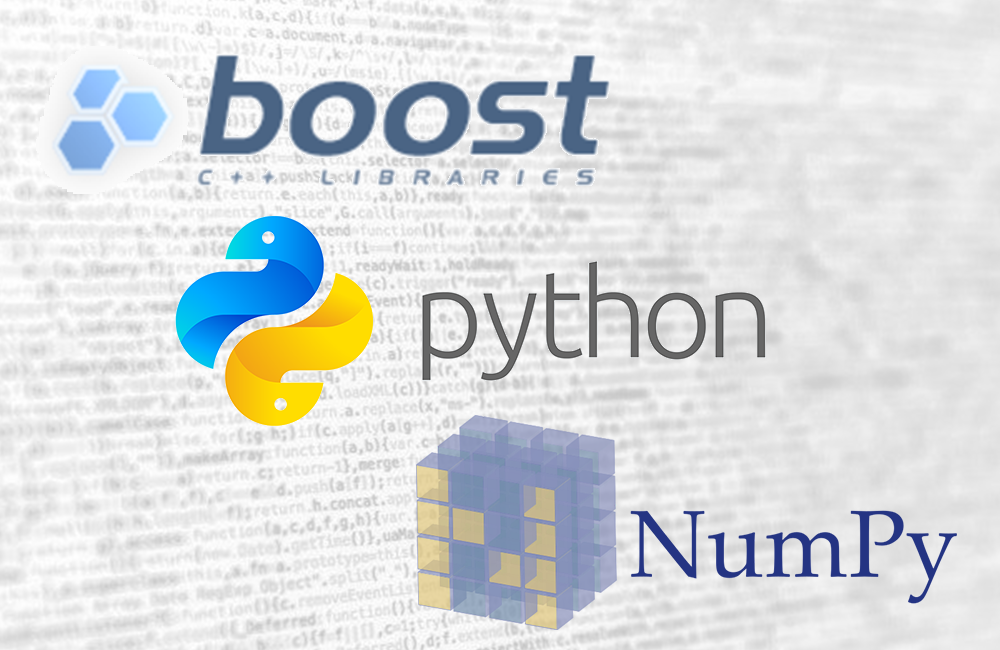

In [7]:
Image("boost/cover.png")

!!! img-main